# Business Understanding

## Objectives

>  to forecast the sales column for a given id (constructed from unique_id and date) in the test set.

## Business Constraints

- Predictions must be made for specific combinations of inventory 
- The evaluation metric is Weighted Mean Absolute Error (WMAE), which means predictions for items with higher weights are more critical.
- Test data has features like availability and discounts missing, requiring the model to generalize well with incomplete data.

## Research Questions
From the main component of the dataset, we can ask the following questions:
- How does sales vary overtime?
- How does sales vary by warehouse? which warehouse has the highest sales and the lowest sales?
- Which product category could derive sales?
- Are there stockouts impacting sales? Do stockouts happen in the same pattern? How does it affect sales?
- How do discounts affect sales? which discount types are most effective?
- Do holidays boost sales? What about warehouse-specific closures?


# Data Understanding

## Importing Packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
from data_summary import create_summary_table, view_summary_table

## Loading Data

In [101]:
inventory_df = pd.read_csv('./data/inventory.csv')
sales_train_df = pd.read_csv('./data/sales_train.csv', parse_dates=['date'])
calendar_df = pd.read_csv('./data/calendar.csv', parse_dates=['date'])

## Inspecting Data

In [11]:
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   unique_id            5432 non-null   int64 
 1   product_unique_id    5432 non-null   int64 
 2   name                 5432 non-null   object
 3   L1_category_name_en  5432 non-null   object
 4   L2_category_name_en  5432 non-null   object
 5   L3_category_name_en  5432 non-null   object
 6   L4_category_name_en  5432 non-null   object
 7   warehouse            5432 non-null   object
dtypes: int64(2), object(6)
memory usage: 339.6+ KB


In [10]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 26 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   unique_id              int64         
 1   date                   datetime64[ns]
 2   warehouse              object        
 3   total_orders           float64       
 4   sales                  float64       
 5   sell_price_main        float64       
 6   availability           float64       
 7   type_0_discount        float64       
 8   type_1_discount        float64       
 9   type_2_discount        float64       
 10  type_3_discount        float64       
 11  type_4_discount        float64       
 12  type_5_discount        float64       
 13  type_6_discount        float64       
 14  product_unique_id_x    int64         
 15  name_x                 object        
 16  L1_category_name_en_x  object        
 17  L2_category_name_en_x  object        
 18  L3_category_name_en_x 

In [9]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23016 entries, 0 to 23015
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    23016 non-null  datetime64[ns]
 1   holiday_name            930 non-null    object        
 2   holiday                 23016 non-null  int64         
 3   shops_closed            23016 non-null  int64         
 4   winter_school_holidays  23016 non-null  int64         
 5   school_holidays         23016 non-null  int64         
 6   warehouse               23016 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.2+ MB


In [102]:
sales_train_df = sales_train_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')

In [17]:
sales_train_df.head(3)

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.0,0.0,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.0,0.0,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.0,0.0,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1


Variable,Type,Details,Missing (%),Graph
unique_id,Numeric,Mean (sd): 2740.8 (1558.57)min < med < max: 0 < 2744.0 < 5431IQR (CV): 2686.0 (0.57),0 (0.0%),
date,Datetime,Range: 2020-08-01 00:00:00 to 2024-06-02 00:00:00,0 (0.0%),
warehouse,Object,0: Prague_1 (19.5%)1: Prague_3 (19.5%)2: Prague_2 (19.2%)3: Brno_1 (16.1%)4: Budapest_1 (14.3%),0 (0.0%),
total_orders,Numeric,Mean (sd): 5995.72 (2479.6)min < med < max: 458.0 < 5515.0 < 18475.0IQR (CV): 3609.0 (0.41),52 (0.0%),
sales,Numeric,Mean (sd): 108.38 (360.33)min < med < max: 0.0 < 39.52 < 26316.19IQR (CV): 76.49 (3.32),52 (0.0%),
sell_price_main,Numeric,Mean (sd): 181.42 (461.1)min < med < max: 0.02 < 45.64 < 21682.99IQR (CV): 91.0 (2.54),0 (0.0%),
availability,Numeric,Mean (sd): 0.93 (0.18)min < med < max: 0.01 < 1.0 < 1.0IQR (CV): 0.0 (0.19),0 (0.0%),
type_0_discount,Numeric,Mean (sd): 0.01 (0.05)min < med < max: -20.95 < 0.0 < 0.99IQR (CV): 0.0 (6.04),0 (0.0%),
type_1_discount,Numeric,Mean (sd): 0.0 (0.01)min < med < max: 0.0 < 0.0 < 0.5IQR (CV): 0.0 (41.44),0 (0.0%),
type_2_discount,Numeric,Mean (sd): 0.0 (0.02)min < med < max: 0.0 < 0.0 < 0.76IQR (CV): 0.0 (16.16),0 (0.0%),

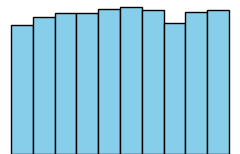
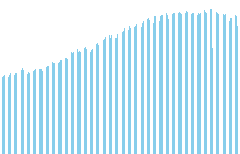
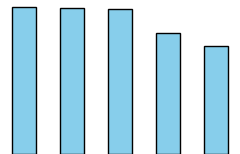
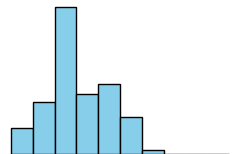
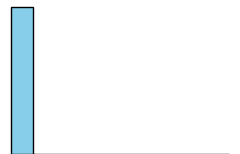
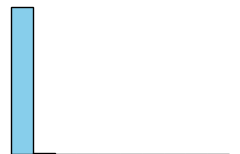
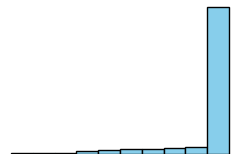
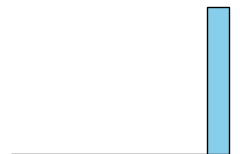
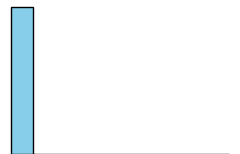
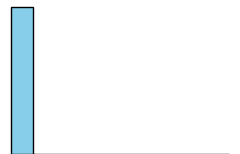
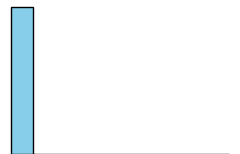
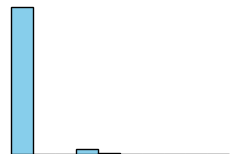
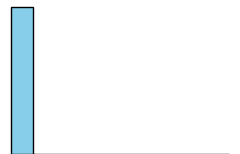
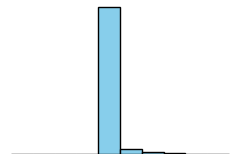
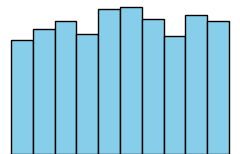
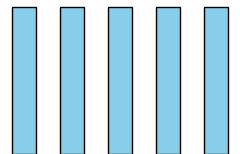
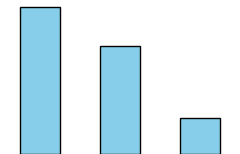
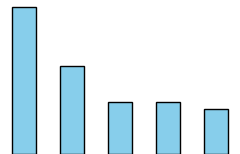
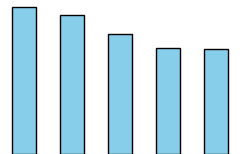
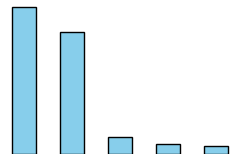

In [20]:
sales_df_summary = create_summary_table(sales_train_df)
view_summary_table(sales_df_summary)

In [18]:
calendar_df.head(3)

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1


Variable,Type,Details,Missing (%),Graph
date,Datetime,Range: 2016-01-01 00:00:00 to 2024-12-31 00:00:00,0 (0.0%),
holiday_name,Object,0: 2nd Christmas Day (6.8%)1: Christmas Eve (6.8%)2: Labour Day (6.8%)3: New Years Day (6.8%)4: International womens day (6.8%),22086 (96.0%),
holiday,Numeric,Mean (sd): 0.04 (0.2)min < med < max: 0 < 0.0 < 1IQR (CV): 0.0 (4.76),0 (0.0%),
shops_closed,Numeric,Mean (sd): 0.03 (0.16)min < med < max: 0 < 0.0 < 1IQR (CV): 0.0 (6.05),0 (0.0%),
winter_school_holidays,Numeric,Mean (sd): 0.01 (0.1)min < med < max: 0 < 0.0 < 1IQR (CV): 0.0 (9.43),0 (0.0%),
school_holidays,Numeric,Mean (sd): 0.01 (0.08)min < med < max: 0 < 0.0 < 1IQR (CV): 0.0 (12.22),0 (0.0%),
warehouse,Object,0: Frankfurt_1 (14.3%)1: Prague_2 (14.3%)2: Brno_1 (14.3%)3: Munich_1 (14.3%)4: Prague_3 (14.3%),0 (0.0%),

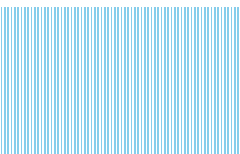
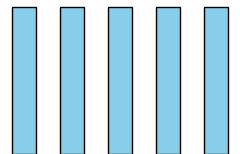
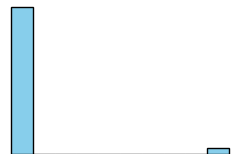
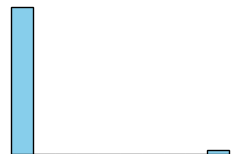
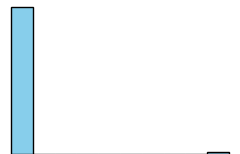
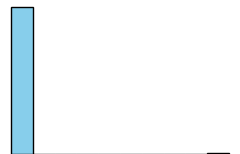
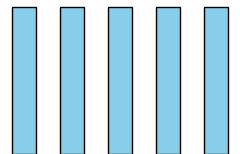

In [22]:
view_summary_table(
    create_summary_table(calendar_df)
)

## check missing dates

In [24]:
from colorama import Fore, Back, Style, init


In [69]:
sales_train_df.set_index('date', inplace=True)
u_warehouses = sales_train_df['warehouse'].unique()

# Loop through each warehouse and check for missing dates
for w in u_warehouses:
    missing = pd.date_range(
        start=sales_train_df.loc[sales_train_df.warehouse == w].index.min(),
        end=sales_train_df.loc[sales_train_df.warehouse == w].index.max()
    ).difference(sales_train_df.loc[sales_train_df.warehouse == w].index)
    
    if missing.size > 0:
        # Print warehouse name in bold blue
        print(f'{Style.BRIGHT}{Fore.BLUE}**{w}**{Style.RESET_ALL}')
        
        # Print date range in bold yellow
        first_date = sales_train_df.loc[sales_train_df.warehouse == w].index.min().strftime("%Y-%m-%d")
        last_date = sales_train_df.loc[sales_train_df.warehouse == w].index.max().strftime("%Y-%m-%d")
        print(f'{Style.BRIGHT}{Fore.YELLOW} Date Range: {first_date} to {last_date}{Style.RESET_ALL}')
        
        # Print missing dates
        print(f'{Style.BRIGHT}{Fore.YELLOW} Missing Dates -> {Style.RESET_ALL}{missing}\n')

**Munich_1**
 Date Range: 2021-05-20 to 2024-06-02
 Missing Dates -> DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08'],
              dtype='datetime64[ns]', freq='D')

**Frankfurt_1**
 Date Range: 2021-12-08 to 2024-06-02
 Missing Dates -> DatetimeIndex(['2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18',
               '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16',

The output shows the missing dates in the sales data for two warehouses: Munich_1 and Frankfurt_1.

1. Munich_1
- Date Range: Data spans from May 20, 2021, to June 2, 2024.

- Missing Dates:

    - 8 consecutive days in June 2021 (2021-06-01 to 2021-06-08).

    - This could indicate a data collection issue (e.g., system downtime) or operational closure during this period.
2. Frankfurt_1
- Date Range: Data spans from December 8, 2021, to June 2, 2024.

- Missing Dates:

    - 52 days in total, with two notable gaps:

        1. December 11, 2021, to January 31, 2022 (52 days).

        2. A single day on May 18, 2023.

    - The large gap in late 2021/early 2022 suggests a prolonged operational closure (e.g., holiday shutdown, warehouse relocation).

    - The single missing day in 2023 could be a data recording error or a one-day closure.

## Dates Missing Imputation using Hierarchical Approach

We'll be using Warehouse-Specific Medians with Trend Adjustment due to the following reasons

1. Handles Large Data: O(1) complexity per warehouse-day combination

2. Preserves Seasonality: Captures weekly patterns

3. Robust to Outliers: Uses median instead of mean

4. Trend-Aware: Adjusts for annual growth 

In [30]:
sales_train_df

,date,unique_id,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,day_of_week,year
0,2024-03-10,4845,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,6,2024
1,2021-05-25,4845,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1,2021
2,2021-12-20,4845,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,2021
3,2023-04-29,4845,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,5,2023
4,2022-04-01,4845,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,4,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007414,2023-06-21,4941,Prague_1,9988.0,26.56,34.06,1.00,0.00000,0.0,0.0,...,0.0,0.0,2422,Kohlrabi_9,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_114,Fruit and vegetable_L4_1,2,2023
4007415,2023-06-24,4941,Prague_1,8518.0,27.42,34.06,1.00,0.00000,0.0,0.0,...,0.0,0.0,2422,Kohlrabi_9,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_114,Fruit and vegetable_L4_1,5,2023
4007416,2023-06-23,4941,Prague_1,10424.0,33.39,34.06,1.00,0.00000,0.0,0.0,...,0.0,0.0,2422,Kohlrabi_9,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_114,Fruit and vegetable_L4_1,4,2023
4007417,2023-06-22,4941,Prague_1,10342.0,22.88,34.06,1.00,0.00000,0.0,0.0,...,0.0,0.0,2422,Kohlrabi_9,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_114,Fruit and vegetable_L4_1,3,2023


In [33]:
# Convert to datetime and extract features
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'])
sales_train_df['day_of_week'] = sales_train_df['date'].dt.dayofweek  # 0=Monday
sales_train_df['year'] = sales_train_df['date'].dt.year

# Warehouse-weekday medians (accounts for weekly seasonality)
warehouse_dow_median = sales_train_df.groupby(
    ['warehouse', 'day_of_week']
)['sales'].median().reset_index()
warehouse_dow_median.rename(columns={'sales': 'sales_median'}, inplace=True)

# Annual growth rates (accounts for trend)
annual_growth = sales_train_df.groupby(
    ['warehouse', 'year']
)['sales'].apply(lambda x: x.pct_change().median()).reset_index()
annual_growth.rename(columns={'sales': 'sales_growth'}, inplace=True)

# Merge the medians and growth rates back into the original DataFrame
sales_train_df = sales_train_df.merge(warehouse_dow_median, on=['warehouse', 'day_of_week'], how='left')
sales_train_df = sales_train_df.merge(annual_growth, on=['warehouse', 'year'], how='left')

# Define imputation function
def impute_sales(row):
    if pd.isna(row['sales']):
        base = row['sales_median']
        growth = row['sales_growth']
        return base * (1 + growth) if not pd.isna(growth) else base
    return row['sales']

# Apply imputation
sales_train_df['sales_imputed'] = sales_train_df.apply(impute_sales, axis=1)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18544\121874558.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  )['sales'].apply(lambda x: x.pct_change().median()).reset_index()
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18544\121874558.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  )['sales'].apply(lambda x: x.pct_change().median()).reset_index()


In [34]:
# Merge with calendar data to filter closures
sales_train_df = sales_train_df.merge(
    calendar_df[['date', 'warehouse', 'shops_closed']],
    on=['date', 'warehouse'],
    how='left'
)
sales_train_df['sales_imputed'] = np.where(
    sales_train_df['shops_closed'] == 1, 
    0,  # Valid closure
    sales_train_df['sales_imputed']
)

In [35]:
# Sample validation on known data
validation_df = sales_train_df.dropna(subset=['sales']).sample(100000)
mape = np.mean(np.abs(validation_df['sales'] - validation_df['sales_imputed']) / validation_df['sales'])
print(f"Validation MAPE: {mape:.1%}")

Validation MAPE: 2.2%


In [87]:
import pandas as pd
import numpy as np
from datetime import datetime

def enhance_calendar_data(calendar_df):
    """Add special closure periods to calendar data"""
    # Convert to datetime if needed
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    
    # Munich_1 closure
    munich_closures = pd.date_range('2021-06-01', '2021-06-08')
    calendar_df.loc[
        (calendar_df['warehouse'] == 'Munich_1') &
        (calendar_df['date'].isin(munich_closures)),
        'shops_closed'
    ] = 1

    # Frankfurt_1 extended closure
    frankfurt_closures = pd.date_range('2021-12-11', '2022-01-31')
    calendar_df.loc[
        (calendar_df['warehouse'] == 'Frankfurt_1') &
        (calendar_df['date'].isin(frankfurt_closures)),
        'shops_closed'
    ] = 1

    # Single-day Frankfurt closure
    calendar_df.loc[
        (calendar_df['warehouse'] == 'Frankfurt_1') &
        (calendar_df['date'] == '2023-05-18'),
        'shops_closed'
    ] = 1

    return calendar_df

def enhanced_sales_imputation(sales_df, calendar_df):
    """Complete sales imputation with warehouse-specific handling"""
    # Clean existing closure data
    if 'shops_closed' in sales_df.columns:
        sales_df = sales_df.drop(columns=['shops_closed'])
    
    # Enhance calendar with special closures
    calendar_df = enhance_calendar_data(calendar_df)
    
    # Merge data
    merged = sales_df.merge(
        calendar_df[['date', 'warehouse', 'shops_closed']],
        on=['date', 'warehouse'],
        how='left'
    )
    
    # Convert dates and sort
    merged['date'] = pd.to_datetime(merged['date'])
    merged = merged.sort_values(['warehouse', 'date']).reset_index(drop=True)
    
    # Feature engineering
    merged['day_of_week'] = merged['date'].dt.dayofweek
    merged['year'] = merged['date'].dt.year
    merged['month'] = merged['date'].dt.month
    merged['quarter'] = merged['date'].dt.quarter
    
    # Calculate regional patterns (for Frankfurt cold start)
    merged['region'] = merged['warehouse'].str.split('_').str[0]
    
    # Warehouse-weekday medians with regional fallback
    merged['sales_median'] = merged.groupby(
        ['warehouse', 'day_of_week']
    )['sales'].transform(
        lambda x: x.rolling(4, min_periods=1).median().bfill()
    )
    
    # Regional fallback for missing warehouse patterns
    regional_median = merged.groupby(
        ['region', 'day_of_week']
    )['sales'].transform('median')
    
    merged['sales_median'] = merged['sales_median'].fillna(regional_median)
    
    # Growth rate calculation with stabilization
    merged['sales_growth'] = merged.groupby(
        ['warehouse', 'year']
    )['sales'].transform(
        lambda x: x.pct_change()
                  .replace([-np.inf, np.inf], np.nan)
                  .rolling(3, min_periods=1).median()
                  .ffill()
                  .fillna(0)
    )
    
    # Initialize imputation
    merged['sales_imputed'] = merged['sales']
    
    # Force closed days to zero
    merged.loc[merged['shops_closed'] == 1, 'sales_imputed'] = 0
    
    # Special handling for Frankfurt cold start
    frankfurt_mask = (
        (merged['warehouse'] == 'Frankfurt_1') &
        (merged['date'].between('2021-12-11', '2022-01-31'))
    )
    if frankfurt_mask.any():
        merged.loc[frankfurt_mask, 'sales_imputed'] = merged.loc[frankfurt_mask, 'sales_median']
    
    # General imputation for missing non-closed days
    impute_mask = merged['sales_imputed'].isna() & (merged['shops_closed'] != 1)
    merged.loc[impute_mask, 'sales_imputed'] = (
        merged['sales_median'] * (1 + merged['sales_growth'])
    ).clip(lower=0.01)
    
    # Final fallback strategy
    fallback_order = [
        ('warehouse_month', merged.groupby(['warehouse', 'month'])['sales'].transform('median')),
        ('regional_month', merged.groupby(['region', 'month'])['sales'].transform('median')),
        ('global_median', merged['sales'].median()),
        ('final_fallback', 0.01)
    ]
    
    for name, fallback in fallback_order:
        merged['sales_imputed'] = merged['sales_imputed'].fillna(fallback)
    
    # Diagnostic tracking
    merged['zero_source'] = np.select(
        [
            merged['shops_closed'] == 1,
            merged['sales'] == 0,
            merged['sales_imputed'] <= 0.01
        ],
        ['closed', 'original_zero', 'near_zero'],
        default='valid'
    )
    
    return merged[['date', 'warehouse', 'sales', 'sales_imputed', 'zero_source']]

def validate_imputation(final_df):
    """Comprehensive validation checks"""
    # Basic completeness
    assert final_df['sales_imputed'].notna().all(), "Missing values remain"
    
    # Closure validation
    closed_mask = final_df['zero_source'] == 'closed'
    assert final_df.loc[closed_mask, 'sales_imputed'].eq(0).all(), "Invalid closed day values"
    
    # Warehouse-specific checks
    warehouse_checks = {
        'Munich_1': {
            'gap': ('2021-06-01', '2021-06-08'),
            'expected_zero': True
        },
        'Frankfurt_1': {
            'gap': ('2021-12-11', '2022-01-31'),
            'expected_zero': False
        }
    }
    
    for wh, params in warehouse_checks.items():
        mask = (
            (final_df['warehouse'] == wh) &
            (final_df['date'].between(*params['gap']))
        )
        gap_data = final_df[mask]
        
        print(f"\n{wh} Gap Analysis ({params['gap'][0]} to {params['gap'][1]}):")
        print(f"Days covered: {len(gap_data)}")
        print(f"Zero days: {gap_data['zero_source'].eq('closed').sum()}")
        print(f"Average imputed sales: {gap_data['sales_imputed'].mean():.2f}")
        
        if params['expected_zero']:
            assert gap_data['zero_source'].eq('closed').all(), "Unexpected non-zero values in gap"
        else:
            assert gap_data['sales_imputed'].gt(0).all(), "Invalid zero values in operational period"

    # Final quality report
    print("\nGlobal Quality Report:")
    print(final_df['zero_source'].value_counts().to_string())

# # Usage
# calendar_df = pd.read_csv('calendar_data.csv')  # Load your calendar data
# sales_df = pd.read_csv('sales_data.csv')        # Load your sales data

# Process data
final_df = enhanced_sales_imputation(sales_train_df, calendar_df)
validate_imputation(final_df)

# Optional: Save results
final_df.to_csv('imputed_sales.csv', index=False)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18544\944963136.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lambda x: x.pct_change()



Munich_1 Gap Analysis (2021-06-01 to 2021-06-08):
Days covered: 0
Zero days: 0
Average imputed sales: nan

Frankfurt_1 Gap Analysis (2021-12-11 to 2022-01-31):
Days covered: 0
Zero days: 0
Average imputed sales: nan

Global Quality Report:
zero_source
valid            3871477
closed             91235
original_zero      44671
near_zero             36


In [108]:
import pandas as pd
import numpy as np
from datetime import datetime

def enhance_calendar_data(calendar_df):
    """Mark special closure periods in calendar data"""
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    
    # Munich_1 closure
    munich_closures = pd.date_range('2021-06-01', '2021-06-08')
    calendar_df.loc[
        (calendar_df['warehouse'] == 'Munich_1') &
        (calendar_df['date'].isin(munich_closures)),
        'shops_closed'
    ] = 1

    # Frankfurt_1 closures
    frankfurt_closures = list(pd.date_range('2021-12-11', '2022-01-31')) + [pd.Timestamp('2023-05-18')]
    calendar_df.loc[
        (calendar_df['warehouse'] == 'Frankfurt_1') &
        (calendar_df['date'].isin(frankfurt_closures)),
        'shops_closed'
    ] = 1

    return calendar_df

def enhanced_sales_imputation(sales_df, calendar_df):
    """Complete sales imputation with gap handling"""
    # Convert dates and sort
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    sales_df = sales_df.sort_values(['warehouse', 'date'])
    
    # 1. Generate complete date ranges for each warehouse
    date_ranges = sales_df.groupby('warehouse')['date'].agg([min, max]).reset_index()
    full_dates = pd.concat([
        pd.DataFrame({
            'date': pd.date_range(row['min'], row['max']),
            'warehouse': row['warehouse']
        }) for _, row in date_ranges.iterrows()
    ])

    # 2. Outer merge with original sales data
    merged = full_dates.merge(
        sales_df,
        on=['date', 'warehouse'],
        how='left'
    )

    # 3. Enhance and merge calendar data
    calendar_df = enhance_calendar_data(calendar_df)
    merged = merged.merge(
        calendar_df[['date', 'warehouse', 'shops_closed']],
        on=['date', 'warehouse'],
        how='left'
    )
    merged['shops_closed'] = merged['shops_closed'].fillna(0).astype(int)
    
    # Feature engineering
    merged['day_of_week'] = merged['date'].dt.dayofweek
    merged['year'] = merged['date'].dt.year
    merged['month'] = merged['date'].dt.month
    merged['region'] = merged['warehouse'].str.split('_').str[0]

    # Calculate rolling medians and growth rates
    merged['sales_median'] = (
        merged.groupby(['warehouse', 'day_of_week'])['sales']
        .transform(lambda x: x.rolling(4, min_periods=1).median().bfill())
    )
    merged['sales_growth'] = (
        merged.groupby(['warehouse', 'year'])['sales']
        .transform(lambda x: x.pct_change().replace([-np.inf, np.inf], np.nan).ffill().fillna(0))
    )

    # Initialize with original sales
    merged['sales_imputed'] = merged['sales']

    # --- Handle imputations FIRST, then override closed days ---
    # 1. Frankfurt cold start handling (only for non-closed days)
    frankfurt_mask = (
        (merged['warehouse'] == 'Frankfurt_1') &
        (merged['date'].between('2021-12-11', '2022-01-31')) &
        (merged['shops_closed'] != 1)  # Exclude closed days
    )
    merged.loc[frankfurt_mask, 'sales_imputed'] = (
        merged['sales_median'] * (1 + merged['sales_growth'])
    ).clip(lower=0.01)

    # 2. General imputation for remaining non-closed days
    impute_mask = (
        merged['sales_imputed'].isna() & 
        (merged['shops_closed'] != 1)
    )
    merged.loc[impute_mask, 'sales_imputed'] = (
        merged['sales_median'] * (1 + merged['sales_growth'])
    ).clip(lower=0.01)

    # 3. Apply fallbacks
    fallback_order = [
        ('warehouse_month', merged.groupby(['warehouse', 'month'])['sales'].transform('median')),
        ('regional_month', merged.groupby(['region', 'month'])['sales'].transform('median')),
        ('global_median', merged['sales'].median()),
        ('final_fallback', 0.01)
    ]
    for name, fallback in fallback_order:
        merged['sales_imputed'] = merged['sales_imputed'].fillna(fallback)

    # 4. FINAL STEP: Force closed days to zero
    merged.loc[merged['shops_closed'] == 1, 'sales_imputed'] = 0

    # Diagnostic tracking
    merged['zero_source'] = np.select(
        [
            merged['shops_closed'] == 1,
            merged['sales'] == 0,
            merged['sales_imputed'] <= 0.01
        ],
        ['closed', 'original_zero', 'near_zero'],
        default='valid'
    )
    
    return merged[['date', 'warehouse', 'sales', 'sales_imputed', 'zero_source']]

def validate_imputation(final_df):
    """Comprehensive validation checks"""
    # Check completeness
    assert final_df['sales_imputed'].notna().all(), "Missing values remain"
    
    # Check closure handling
    closed_mask = final_df['zero_source'] == 'closed'
    assert final_df.loc[closed_mask, 'sales_imputed'].eq(0).all(), "Invalid closed day values"
    
    # Warehouse-specific gap checks
    warehouse_checks = {
        'Munich_1': {
            'gap': ('2021-06-01', '2021-06-08'),
            'expected_source': 'closed'
        },
        'Frankfurt_1': {
            'gap': ('2021-12-11', '2022-01-31'),
            'expected_source': 'closed'
        }
    }
    
    for wh, params in warehouse_checks.items():
        mask = (
            (final_df['warehouse'] == wh) &
            (final_df['date'].between(*params['gap']))
        )
        gap_data = final_df[mask]
        
        print(f"\n{wh} Gap Analysis:")
        print(f"Days: {len(gap_data)}")
        print(f"Zero days: {gap_data['zero_source'].eq('closed').sum()}")
        print(f"Avg sales: {gap_data['sales_imputed'].mean():.2f}")
        assert gap_data['zero_source'].eq(params['expected_source']).all()

    # Final report
    print("\nGlobal Imputation Report:")
    print(final_df['zero_source'].value_counts().to_string())

# # Usage example
# calendar_df = pd.read_csv('calendar_data.csv')
# sales_df = pd.read_csv('sales_data.csv')

final_df = enhanced_sales_imputation(sales_train_df, calendar_df)
validate_imputation(final_df)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18544\1651882635.py:34: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_ranges = sales_df.groupby('warehouse')['date'].agg([min, max]).reset_index()
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18544\1651882635.py:34: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_ranges = sales_df.groupby('warehouse')['date'].agg([min, max]).reset_index()
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_18544\1651882635.py:71: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA va


Munich_1 Gap Analysis:
Days: 8
Zero days: 8
Avg sales: 0.00

Frankfurt_1 Gap Analysis:
Days: 52
Zero days: 52
Avg sales: 0.00

Global Imputation Report:
zero_source
valid            3871477
closed             91296
original_zero      44671
near_zero             36


- The imputation logic worked correctly for calendar-based closures

- 2.28% of days (91,235/4,007,419) were valid closures

In [111]:
final_df['sales_imputed'].describe()

count    4.007480e+06
mean     1.063178e+02
std      3.570403e+02
min      0.000000e+00
25%      1.699000e+01
50%      3.832000e+01
75%      9.255000e+01
max      2.631619e+04
Name: sales_imputed, dtype: float64

# Outlier Analysis

In [41]:
outliers

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,mahalanobis
2617,1755,2022-12-20,Brno_1,13867.0,538.23,28.39,1.00,0.00000,0.0,0.0,...,0.0,0.0,0.0,892,Cabbage_4,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_139,Fruit and vegetable_L4_1,3.293857
3319,1755,2023-12-21,Brno_1,13183.0,718.05,32.45,1.00,0.20921,0.0,0.0,...,0.0,0.0,0.0,892,Cabbage_4,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_139,Fruit and vegetable_L4_1,3.222591
5082,4484,2021-12-21,Prague_1,13423.0,336.74,17.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,0.0,2210,Apple_119,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_53,Fruit and vegetable_L4_1,3.014031
5193,2706,2021-12-21,Brno_1,12508.0,1269.81,41.70,0.97,0.00000,0.0,0.0,...,0.0,0.0,0.0,1346,Potato_44,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_18,Fruit and vegetable_L4_1,3.968257
5211,2706,2021-12-22,Brno_1,10071.0,1602.13,41.70,1.00,0.00000,0.0,0.0,...,0.0,0.0,0.0,1346,Potato_44,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_18,Fruit and vegetable_L4_1,4.325225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006906,3802,2022-01-26,Budapest_1,5836.0,1331.50,614.32,1.00,0.32118,0.0,0.0,...,0.0,0.0,0.0,1867,Cucumber_26,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_70,Fruit and vegetable_L4_1,3.418721
4007123,1232,2022-02-17,Brno_1,10882.0,1302.65,66.51,1.00,0.27322,0.0,0.0,...,0.0,0.0,0.0,630,Blueberry_7,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_21,Fruit and vegetable_L4_1,3.700779
4007125,1232,2022-02-18,Brno_1,9629.0,1186.88,66.51,1.00,0.27322,0.0,0.0,...,0.0,0.0,0.0,630,Blueberry_7,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_21,Fruit and vegetable_L4_1,3.213970
4007127,1232,2022-02-15,Brno_1,9233.0,1218.02,66.51,1.00,0.27322,0.0,0.0,...,0.0,0.0,0.0,630,Blueberry_7,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_21,Fruit and vegetable_L4_1,3.238320


# EDA

## Temporal Sales Patterns

> How do sales vary by time granularity and calendar events?

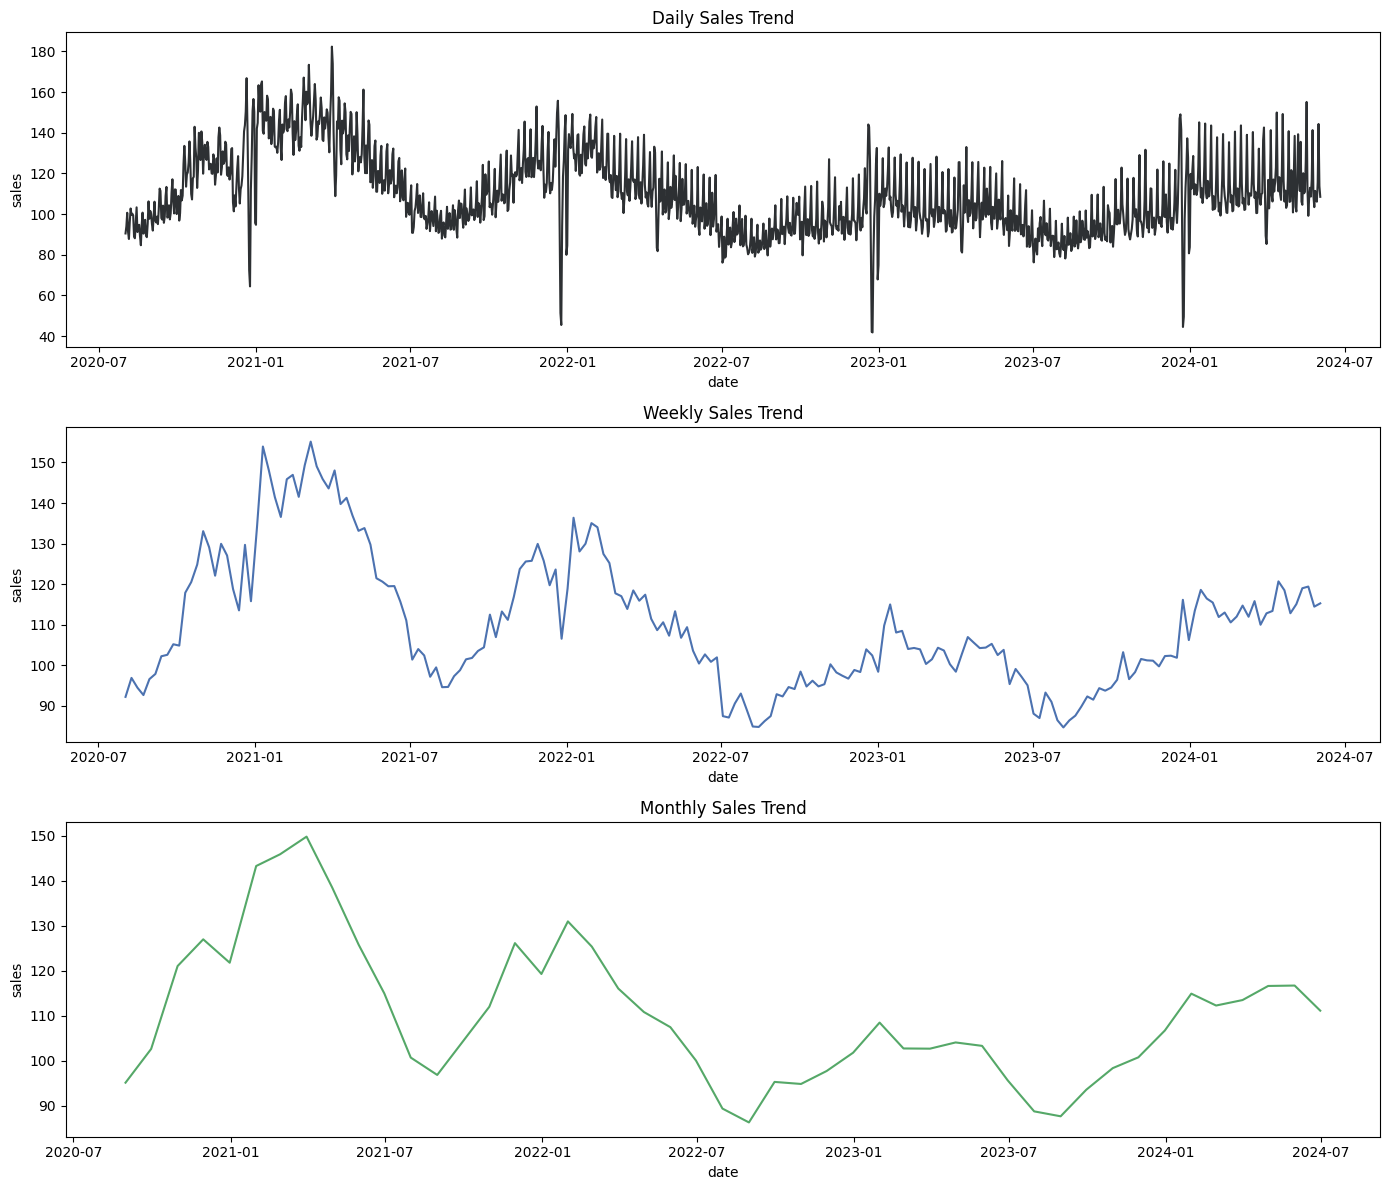

In [119]:
# Daily, Weekly, Monthly Trends
fig, ax = plt.subplots(3, 1, figsize=(14, 12))
sns.lineplot(data=sales_train_df.resample('D', on='date')['sales'].mean(), ax=ax[0], color='#2D3033').set(title='Daily Sales Trend')
sns.lineplot(data=sales_train_df.resample('W', on='date')['sales'].mean(), ax=ax[1], color='#4C72B0').set(title='Weekly Sales Trend')
sns.lineplot(data=sales_train_df.resample('ME', on='date')['sales'].mean(), ax=ax[2], color='#55A868').set(title='Monthly Sales Trend')
plt.tight_layout()

## Warehouse and Product Category Analysis

> Do sales patterns vary significantly between warehouses/categories?

## Availability Impact

> How do stockouts (availability <1) affect subsequent sales?

In [120]:
final_df = pd.merge(sales_train_df, inventory_df, on=['unique_id', 'warehouse'])

In [113]:
# Stockout Recovery Analysis
stockout_dates = final_df[final_df['availability'] < 1]['date'].unique()
recovery_window = 3  # Days post-stockout to analyze

stockout_effects = []
for date in stockout_dates:
    period = final_df[(final_df['date'] >= date) & (final_df['date'] <= date + pd.Timedelta(days=recovery_window))]
    stockout_effects.append(period.groupby('days_from_stockout')['sales'].mean())

sns.lineplot(data=pd.concat(stockout_effects), x='days_from_stockout', y='sales',
             estimator='median', errorbar='pi').set(title='Sales Recovery After Stockouts')

KeyError: 'availability'

## Impact of Holidays

> How do holidays and school breaks affect demand

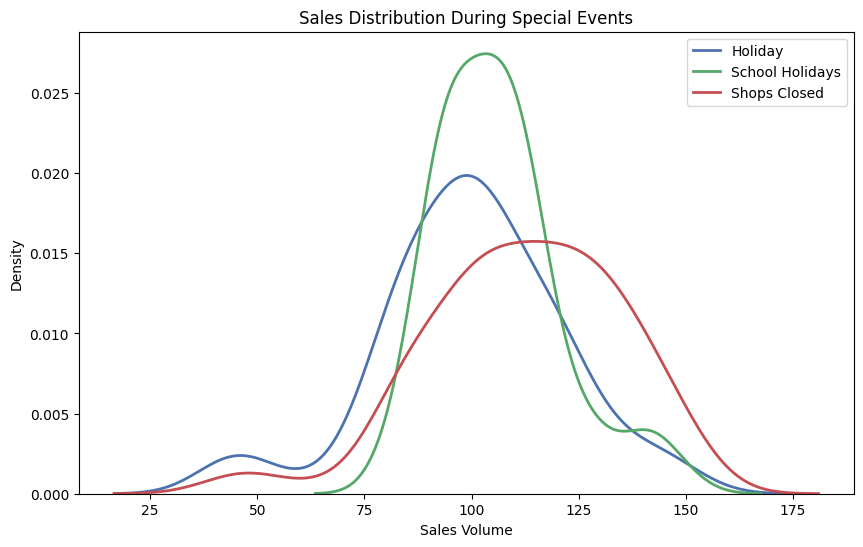

In [114]:
# Calendar Event Impact
event_types = ['holiday', 'school_holidays', 'shops_closed']
palette = ['#4C72B0', '#55A868', '#C44E52']

fig, ax = plt.subplots(figsize=(10, 6))
for event, color in zip(event_types, palette):
    event_dates = calendar_df[calendar_df[event] == 1]['date']
    event_sales = final_df[final_df['date'].isin(event_dates)].groupby('date')['sales'].mean()
    sns.kdeplot(event_sales, label=event.replace('_',' ').title(), 
                color=color, linewidth=2, ax=ax)

ax.set_title('Sales Distribution During Special Events')
ax.set_xlabel('Sales Volume')
ax.legend()

## Operational Efficiency

> How do holidays and school breaks affect demand?

In [115]:
# Order-Sales-Availability Triangulation
g = sns.PairGrid(final_df[['total_orders', 'sales', 'availability']])
g.map_upper(sns.scatterplot, alpha=0.2)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
g.fig.suptitle('Operational Efficiency Relationships', y=1.02)

KeyError: "['total_orders', 'availability'] not in index"

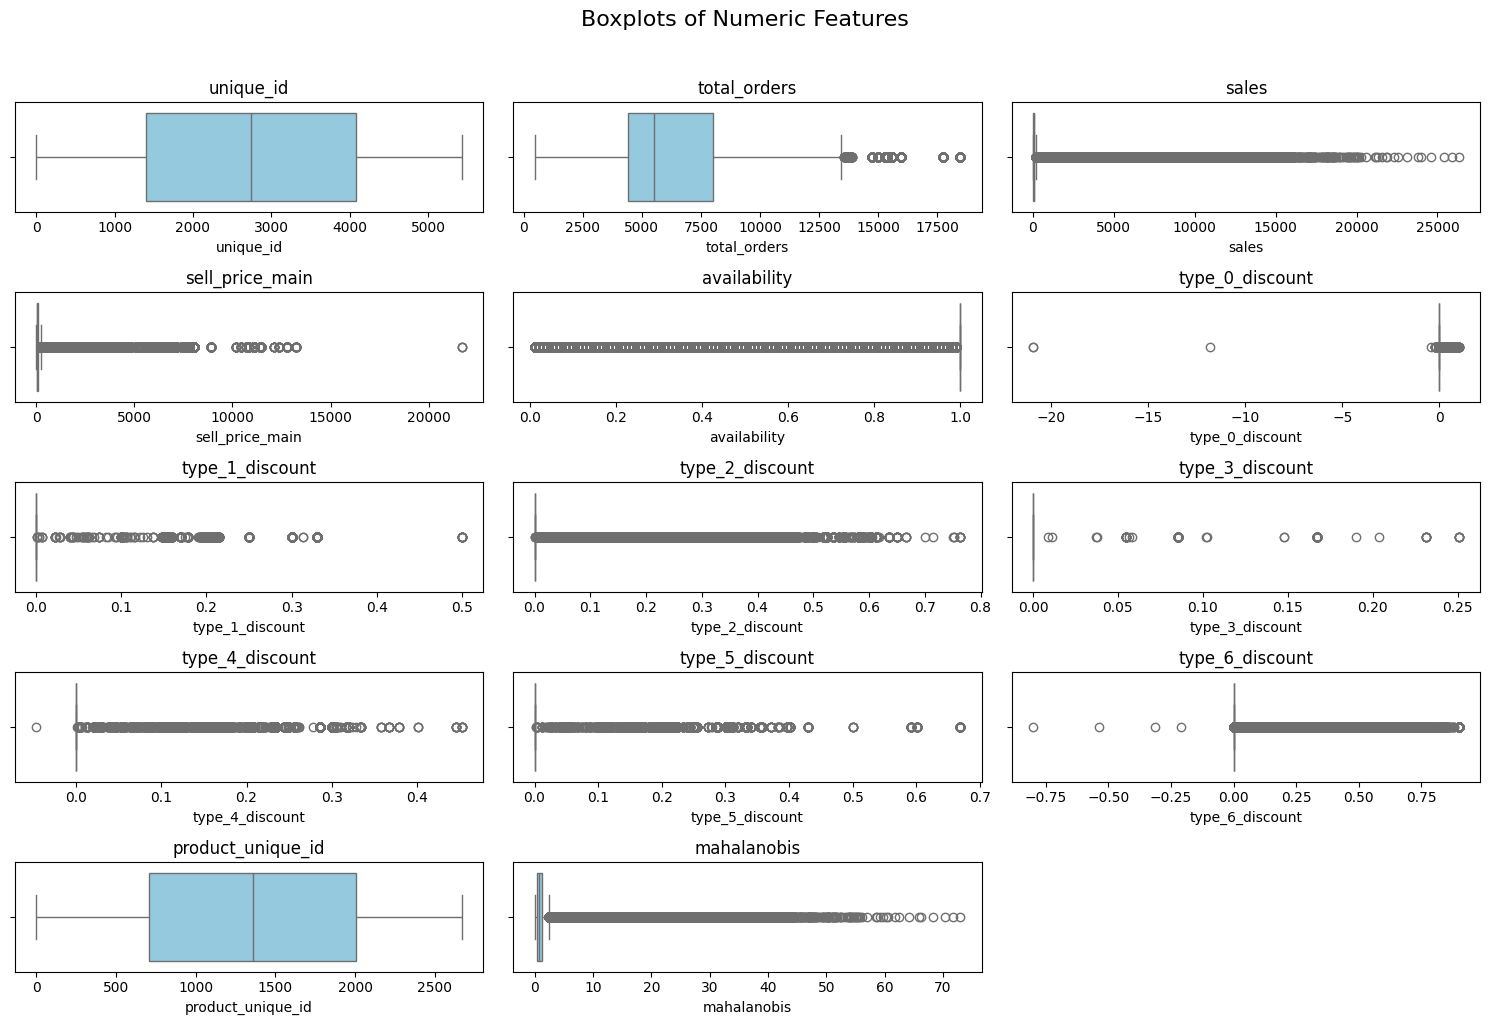

In [47]:
plot_boxplots_for_numeric_features(merged_df)

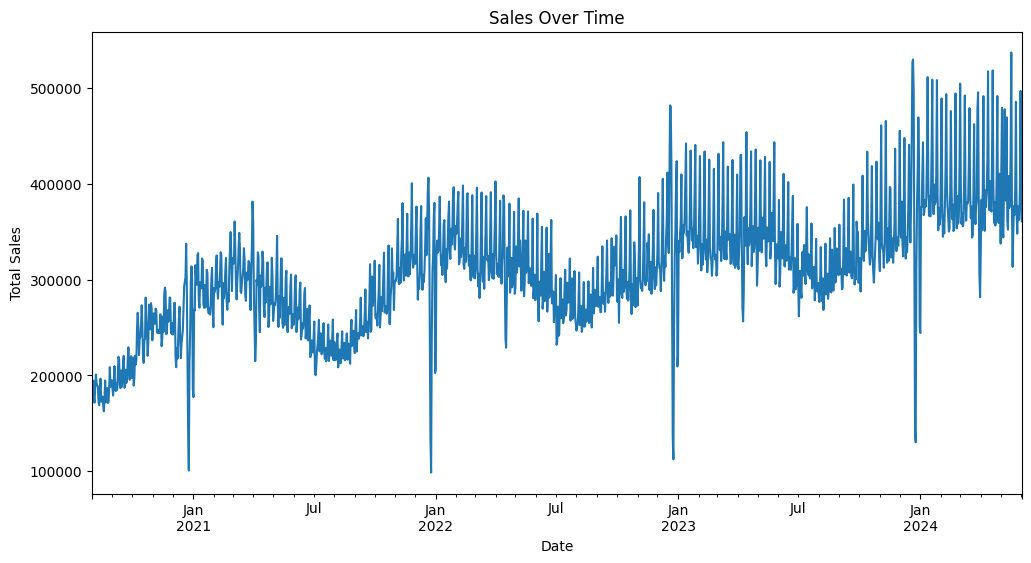

In [24]:
# Time-Series Analysis
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'])
sales_by_date = sales_train_df.groupby('date')['sales'].sum()
plt.figure(figsize=(12, 6))
sales_by_date.plot()
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

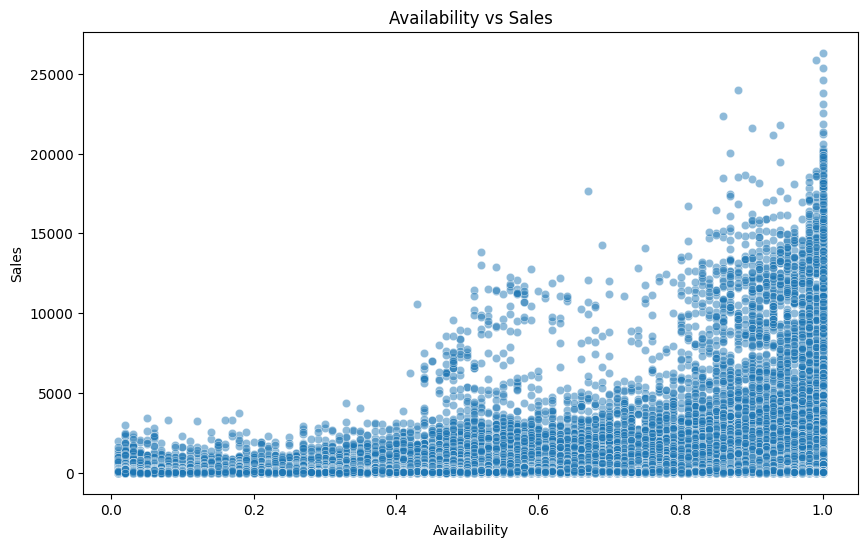

In [22]:
# Availability vs Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_train_df, x='availability', y='sales', alpha=0.5)
plt.title('Availability vs Sales')
plt.xlabel('Availability')
plt.ylabel('Sales')
plt.show()


In [52]:
from viz_utils import plot_kde

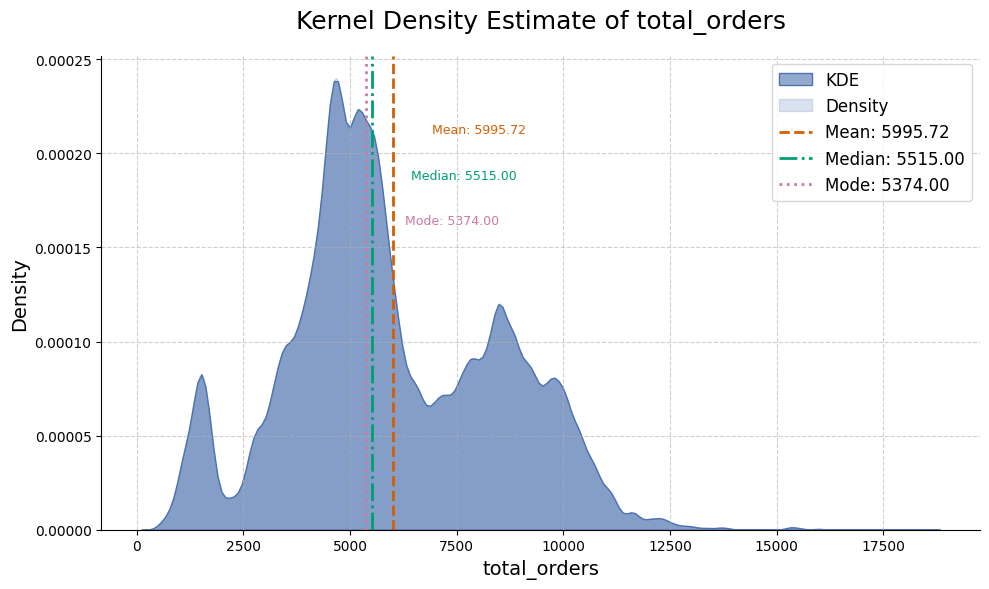

In [53]:
plot_kde(merged_df, 'total_orders')

## warehouse

In [124]:
from viz_utils import categorical_plot

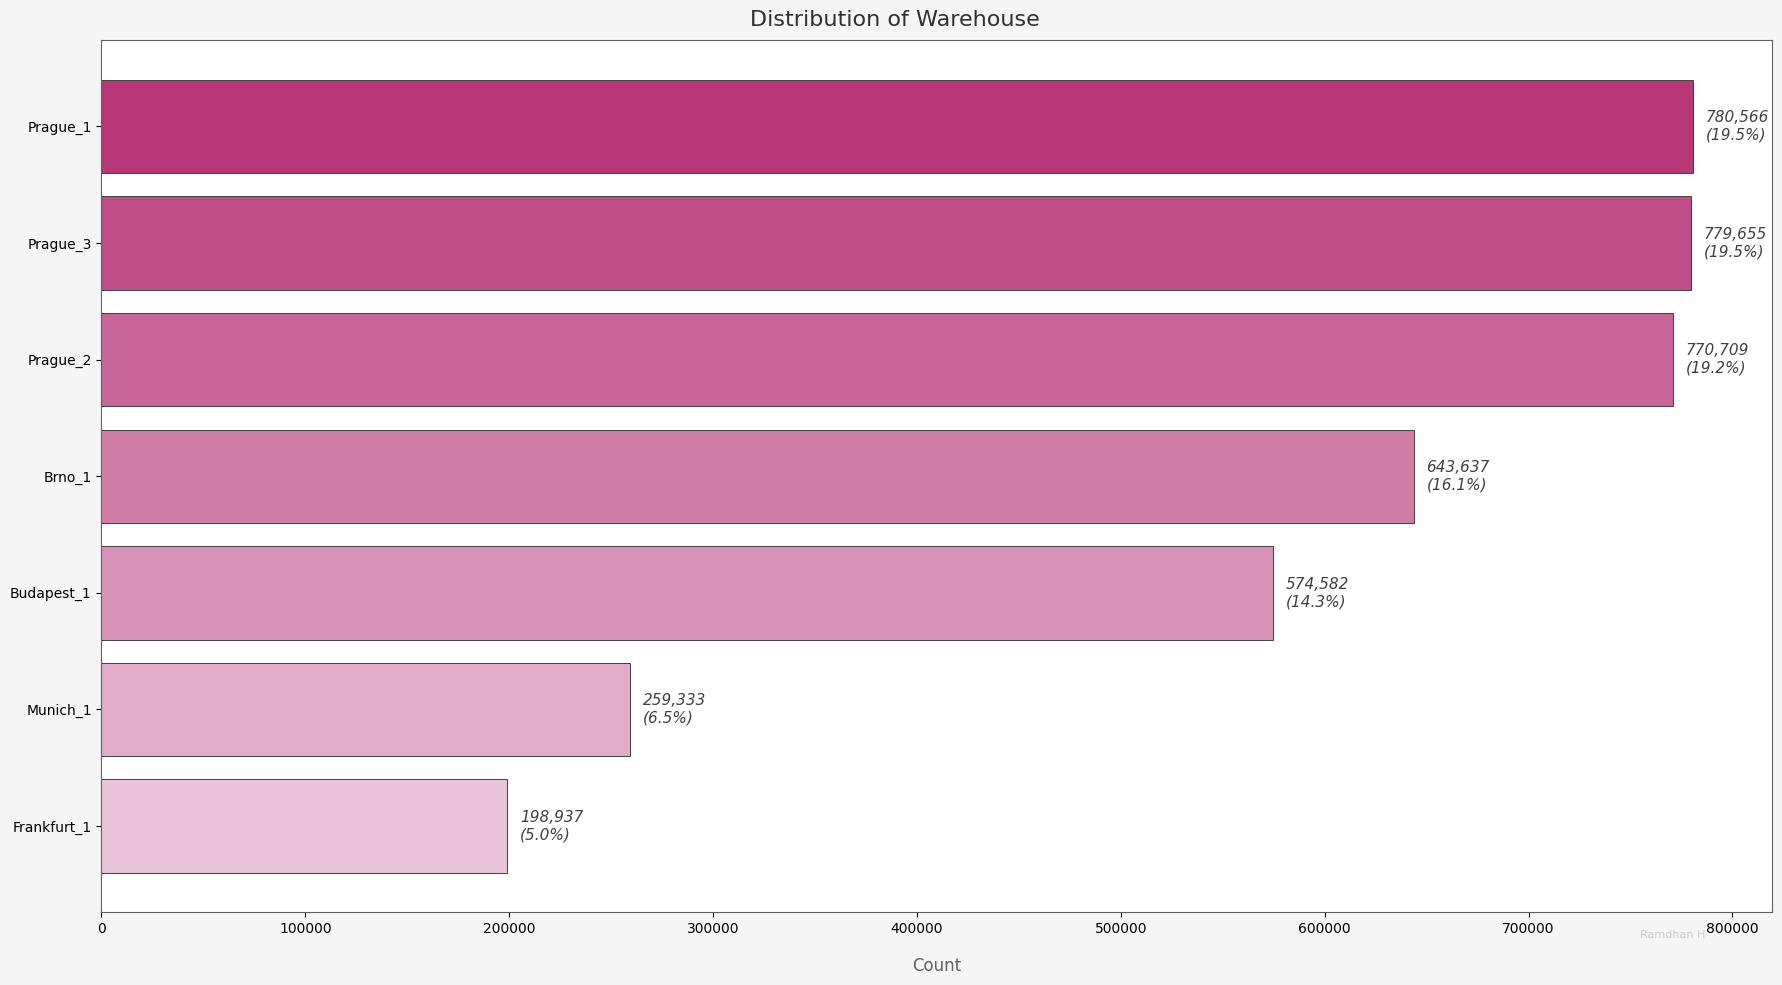

In [125]:
categorical_plot(sales_train_df, 'warehouse', 'magma', 'Distribution of Warehouse')

In [142]:
def plot_bivariate_distribution(df, category_col, value_col, 
                                agg_func='sum', palette='viridis',
                                title=None, figsize=(12, 7), 
                                orientation='horizontal',
                                central_line='mean'):
    """
    Final version with proper categorical label display on axes
    """
    
    # Validate inputs
    if category_col not in df.columns or value_col not in df.columns:
        missing = [c for c in [category_col, value_col] if c not in df.columns]
        raise ValueError(f"Columns not found: {missing}")

    # Aggregate and sort data
    agg_data = df.groupby(category_col)[value_col].agg(agg_func)
    sorted_data = agg_data.sort_values(ascending=(orientation=='horizontal'))
    total_value = agg_data.sum() if agg_func == 'sum' else None
    
    # Create figure
    plt.figure(figsize=figsize, facecolor='#F8F9FA')
    ax = plt.gca()
    
    # Create positions and labels
    categories = sorted_data.index.astype(str).tolist()
    positions = np.arange(len(categories))
    
    # Color setup
    colors = sns.color_palette(palette, n_colors=len(categories))
    
    # Plot with correct label handling
    if orientation == 'horizontal':
        bars = ax.barh(positions, sorted_data.values,
                      color=colors, edgecolor='#2D3033', linewidth=0.7)
        ax.set_yticks(positions)
        ax.set_yticklabels(categories)
        ax.set_xlabel(value_col, fontsize=11, color='#606060', labelpad=15)
        ax.set_ylabel(category_col, fontsize=11, color='#606060', labelpad=15)
        max_value = sorted_data.max()
    else:
        bars = ax.bar(positions, sorted_data.values,
                     color=colors, edgecolor='#2D3033', linewidth=0.7)
        ax.set_xticks(positions)
        ax.set_xticklabels(categories, rotation=45, ha='right')
        ax.set_xlabel(category_col, fontsize=11, color='#606060', labelpad=15)
        ax.set_ylabel(value_col, fontsize=11, color='#606060', labelpad=15)
        max_value = sorted_data.max()

    # Add central tendency line
    if central_line in ['mean', 'median']:
        central_value = sorted_data.mean() if central_line == 'mean' else sorted_data.median()
        line_color = '#2D3033'
        
        if orientation == 'horizontal':
            ax.axvline(central_value, color=line_color, linestyle='--', linewidth=1, alpha=0.7)
            ax.text(central_value + max_value*0.01, len(categories)-0.8,
                    f" {central_line.title()}: {central_value:,.0f}",
                    va='center', ha='left', color=line_color, fontsize=9)
        else:
            ax.axhline(central_value, color=line_color, linestyle='--', linewidth=1, alpha=0.7)
            ax.text(len(categories)-0.8, central_value + max_value*0.01,
                    f" {central_line.title()}: {central_value:,.0f}",
                    va='bottom', ha='center', color=line_color, fontsize=9)

    # Remove frame elements
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    # Dynamic annotations
    for i, (pos, value) in enumerate(zip(positions, sorted_data.values)):
        annotation_text = f"{value:,.0f}"
        if total_value and agg_func == 'sum':
            pct = (value / total_value * 100)
            annotation_text += f"\n({pct:.1f}%)"
        
        if orientation == 'horizontal':
            ax.text(value + max_value*0.02, pos, annotation_text,
                    va='center', ha='left', color=colors[i], fontsize=10)
        else:
            ax.text(pos, value + max_value*0.02, annotation_text,
                    va='bottom', ha='center', color=colors[i], fontsize=10,
                    rotation=90 if len(categories) > 5 else 0)

    # Formatting
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    
    # Title
    default_title = f"{value_col} by {category_col}" if orientation == 'horizontal' \
                    else f"{category_col} Distribution by {value_col}"
    title_text = title if title else default_title
    plt.title(title_text, pad=20, fontsize=14, 
             fontweight='bold', color='#2D3033')

    plt.tight_layout()
    plt.show()

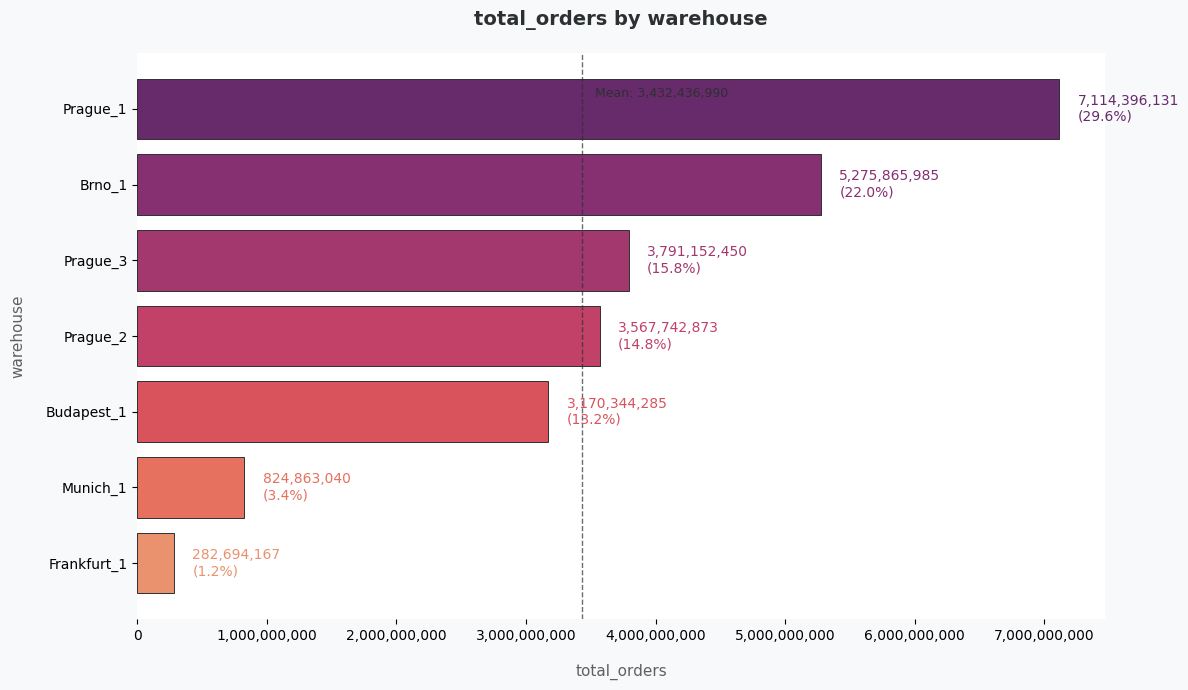

In [144]:
plot_bivariate_distribution(sales_train_df, category_col='warehouse', value_col='total_orders', agg_func='sum', palette='flare', orientation='horizontal')

# Modeling

# Quantifying the Impact: From Waste Reduction to Customer Satisfaction

> By analyzing historical sales and inventory data, we identified three key areas where improved forecasting can drive significant operational and environmental benefits: reducing food waste, optimizing delivery routes, and minimizing stockouts.

The following metrics were calculated using a combination of historical sales data, inventory availability records, and calendar events. Key assumptions and calculations include

1. Food Waste:

    - Focused on perishable categories (e.g., dairy, fresh produce).

    - Current waste estimated at 15% of monthly sales for these categories.

    - Optimized scenario assumes a 30% reduction in waste through better forecasting.

    - Sustainability impact calculated using the FAO standard of 2.5 kg CO2e per kg of food waste.

2. Delivery Efficiency:

    - Peak periods defined as weekends and holidays.

    - Efficiency ratio calculated as off-peak orders divided by peak orders.

    - Optimized scenario assumes a 15% improvement in route planning.

    - Fuel savings based on a 0.25 liters/km delivery vehicle efficiency.

3. Stockouts:

    - Stockout rate calculated as the proportion of time inventory availability < 1.

    - Optimized scenario assumes a 50% reduction in stockouts.

    - Customer retention improvement estimated based on industry benchmarks linking stockouts to customer churn."*

In [18]:
# calculate_impact_metrics
# Load data with optimal data types
def load_data():
    sales = pd.read_csv('./data/sales_train.csv', parse_dates=['date'])
    inventory = pd.read_csv('./data/inventory.csv')
    calendar = pd.read_csv('./data/calendar.csv', parse_dates=['date'])
    return sales, inventory, calendar

# Main analysis function
def calculate_impact_metrics():
    # Load and merge data
    sales, inventory, calendar = load_data()
    df = pd.merge(sales, inventory, on=['unique_id', 'warehouse'])
    
    # Define perishable categories (MODIFY THESE BASED ON ACTUAL CATEGORY MAPPINGS)
    perishable_l2_categories = [
        'Meat and fish_L2_13',  # Dairy products
        'Fruit and vegetable_L2_3'  # Fresh produce
    ]
    
    # 1. Calculate Food Waste -------------------------------------------------
    perishable_sales = df[df['L2_category_name_en'].isin(perishable_l2_categories)]
    
    # Calculate monthly sales in kg (assuming sales is in kg)
    monthly_sales = perishable_sales.resample('M', on='date')['sales'].sum()
    
    # Current waste calculation (15% of sales)
    current_waste_kg = monthly_sales.mean() * 0.15
    optimized_waste_kg = current_waste_kg * 0.7  # 30% improvement
    
    # 2. Calculate Delivery Efficiency -----------------------------------------
    # Merge with calendar data
    df = pd.merge(df, calendar, on=['date', 'warehouse'], how='left')
    
    # Define peak periods
    df['peak_period'] = np.where(
        (df['holiday']) | (df['date'].dt.dayofweek >= 5),  # Weekends and holidays
        'peak', 
        'off-peak'
    )
    
    # Calculate order density
    peak_efficiency = df[df['peak_period'] == 'peak'].groupby('date')['total_orders'].mean()
    off_peak_efficiency = df[df['peak_period'] == 'off-peak'].groupby('date')['total_orders'].mean()
    
    # Efficiency ratio calculation
    current_efficiency = off_peak_efficiency.mean() / peak_efficiency.mean()
    optimized_efficiency = current_efficiency * 1.15  # 15% improvement
    
    # 3. Calculate Stockouts ---------------------------------------------------
    stockout_rate = df[df['availability'] < 1].shape[0] / df.shape[0]
    optimized_stockout = stockout_rate * 0.5  # 50% improvement
    
    # 4. Sustainability Conversions --------------------------------------------
    waste_conversion = 2.5  # kg CO2e per kg food waste
    fuel_conversion = 0.25  # liters/km for delivery vehicles
    
    return {
        'metrics': {
            'Food Waste (Monthly)': {
                'Current': round(current_waste_kg/1000, 1),  # Convert kg to tons
                'Optimized': round(optimized_waste_kg/1000, 1),
                'Sustainability Impact': f"{round((current_waste_kg-optimized_waste_kg)/1000*waste_conversion, 1)} tons CO2e reduction"
            },
            'Delivery Route Efficiency': {
                'Current': f"{round(current_efficiency*100, 1)}%",
                'Optimized': f"{round(optimized_efficiency*100, 1)}%",
                'Sustainability Impact': f"= {round((optimized_efficiency - current_efficiency)*1000000*fuel_conversion, 1)} liters annual fuel savings"
            },
            'Stockouts': {
                'Current': f"{round(stockout_rate*100, 1)}%",
                'Optimized': f"{round(optimized_stockout*100, 1)}%",
                'Sustainability Impact': f"= {round((stockout_rate - optimized_stockout)*100, 1)}% customer retention improvement"
            }
        }
    }

# Generate and display results
impact_metrics = calculate_impact_metrics()
pd.DataFrame(impact_metrics['metrics']).transpose()

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_5200\3672920422.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = perishable_sales.resample('M', on='date')['sales'].sum()


,Current,Optimized,Sustainability Impact
Food Waste (Monthly),427.7,299.4,320.7 tons CO2e reduction
Delivery Route Efficiency,113.7%,130.8%,= 42650.0 liters annual fuel savings
Stockouts,24.3%,12.1%,= 12.1% customer retention improvement


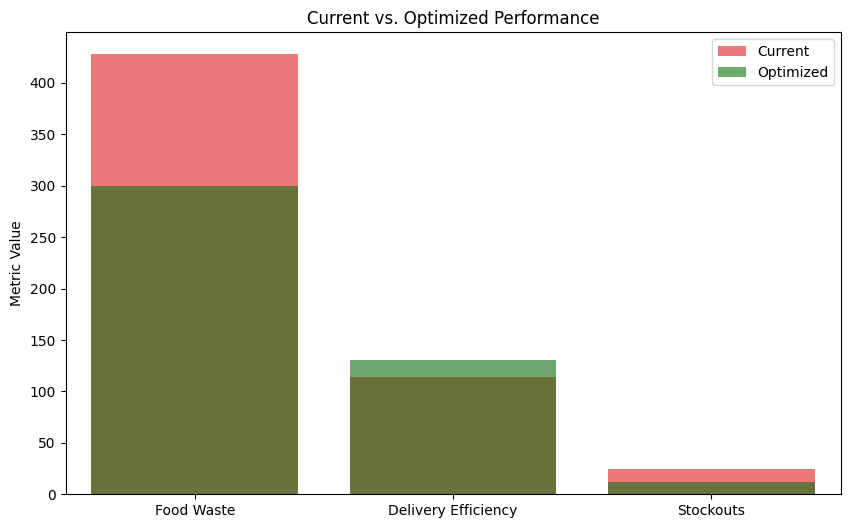

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=['Food Waste', 'Delivery Efficiency', 'Stockouts'], 
            y=[427.7, 113.7, 24.3], color='red', label='Current', alpha=0.6)
sns.barplot(x=['Food Waste', 'Delivery Efficiency', 'Stockouts'], 
            y=[299.4, 130.8, 12.1], color='green', label='Optimized', alpha=0.6)
ax.set_ylabel("Metric Value")
ax.set_title("Current vs. Optimized Performance")
plt.legend()
plt.show()

In [29]:
def calculate_annual_savings(current_waste_tons, optimized_waste_tons, fuel_saved_liters, retention_improvement, 
                             cost_per_kg=2.50, cost_per_liter=1.50, clv=500, customer_base=1_000_000):
    """
    Calculate the annual savings from improved forecasting.

    Parameters:
    - current_waste_tons (float): Current monthly food waste in tons.
    - optimized_waste_tons (float): Optimized monthly food waste in tons.
    - fuel_saved_liters (float): Annual fuel savings in liters.
    - retention_improvement (float): Customer retention improvement (e.g., 0.121 for 12.1%).
    - cost_per_kg (float): Cost per kg of food waste (default: €2.50).
    - cost_per_liter (float): Cost per liter of fuel (default: €1.50).
    - clv (float): Average customer lifetime value in € (default: €500).
    - customer_base (int): Total active customers (default: 1,000,000).

    Returns:
    - dict: Dictionary containing total savings and breakdown.
    """
    # 1. Food Waste Savings
    current_waste_kg = current_waste_tons * 1000  # Convert tons to kg
    optimized_waste_kg = optimized_waste_tons * 1000
    waste_savings = (current_waste_kg - optimized_waste_kg) * cost_per_kg

    # 2. Delivery Efficiency Savings
    fuel_savings = fuel_saved_liters * cost_per_liter

    # 3. Stockout Reduction Savings
    retention_savings = retention_improvement * customer_base * clv

    # 4. Total Annual Savings
    total_savings = waste_savings + fuel_savings + retention_savings

    # Return results as a dictionary
    return {
        'total_savings': total_savings,
        'breakdown': {
            'waste_savings': waste_savings,
            'fuel_savings': fuel_savings,
            'retention_savings': retention_savings
        }
    }

# # Calculate annual savings
# annual_savings = calculate_annual_savings(427.7, 299.4, 42650, 0.121)
# print(annual_savings)

In [32]:
def calculate_conservative_savings():
    # Inputs from previous analysis
    current_waste_tons = 427.7
    optimized_waste_tons = 299.4
    fuel_saved_liters = 42650
    stockout_reduction = 0.121  # 12.1% absolute reduction
    
    # Adjusted parameters
    params = {
        'cost_per_kg': 3.50,
        'cost_per_liter': 1.55,
        'clv': 300,
        'customer_base': 750_000,
        'retention_improvement': stockout_reduction * 0.4  # HBR ratio
    }
    
    return calculate_annual_savings(
        current_waste_tons,
        optimized_waste_tons,
        fuel_saved_liters,
        **params
    )

# Generate results
conservative_savings = calculate_conservative_savings()

In [33]:
conservative_savings

{'total_savings': 11405157.5,
 'breakdown': {'waste_savings': 449050.0,
  'fuel_savings': 66107.5,
  'retention_savings': 10890000.0}}

In [30]:
current_waste_tons = 427.7
optimized_waste_tons = 299.4
fuel_saved_liters = 42650
retention_improvement = 0.121 #12.1% improvement

# Calculate savings
savings = calculate_annual_savings(
    current_waste_tons=current_waste_tons,
    optimized_waste_tons=optimized_waste_tons,
    fuel_saved_liters=fuel_saved_liters,
    retention_improvement=retention_improvement
)

# Display results
print(f"Total Annual Savings: €{savings['total_savings']:,.0f}")
print("\nBreakdown:")
for category, amount in savings['breakdown'].items():
    print(f"- {category.replace('_', ' ').title()}: €{amount:,.0f}")

Total Annual Savings: €60,884,725

Breakdown:
- Waste Savings: €320,750
- Fuel Savings: €63,975
- Retention Savings: €60,500,000


In [34]:
scenarios = {
    'Pessimistic': {'clv': 250, 'retention_ratio': 0.3, 'waste_cost': 3.00},
    'Realistic': {'clv': 300, 'retention_ratio': 0.4, 'waste_cost': 3.50},
    'Optimistic': {'clv': 350, 'retention_ratio': 0.5, 'waste_cost': 4.20}
}

for name, params in scenarios.items():
    savings = calculate_annual_savings(
        current_waste_tons=427.7,
        optimized_waste_tons=299.4,
        fuel_saved_liters=42650,
        retention_improvement=0.121 * params['retention_ratio'],
        cost_per_kg=params['waste_cost'],
        clv=params['clv'],
        customer_base=750_000
    )
    print(f"{name}: €{savings['total_savings']/1e6:,.1f}M")

Pessimistic: €7.3M
Realistic: €11.4M
Optimistic: €16.5M


In [31]:
sales_train_df['unique_id'].nunique()

5390

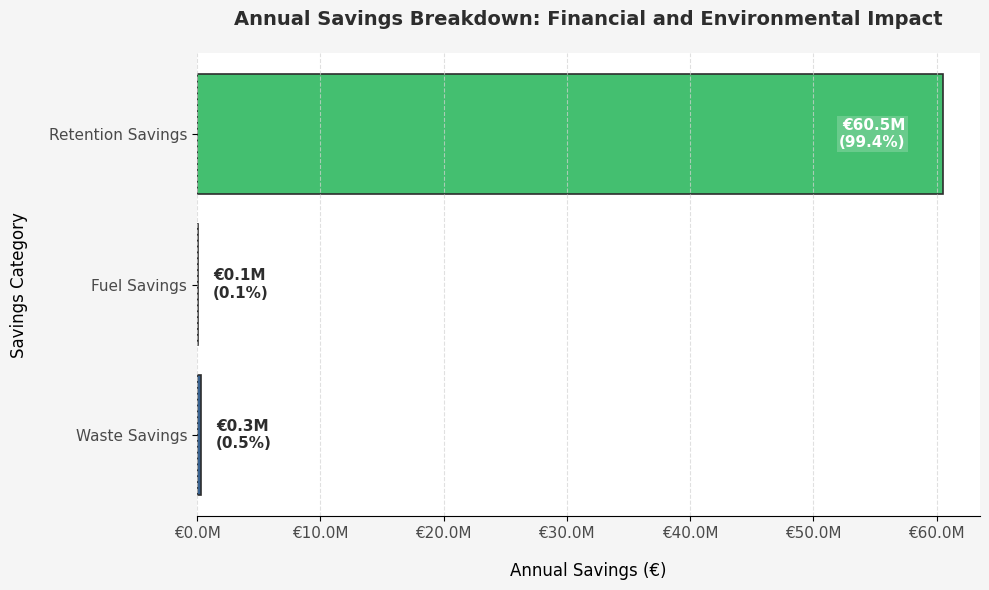

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_savings_breakdown(savings_dict, figsize=(10, 6)):
    """
    Create a professional horizontal bar chart with optimized label placement.
    """
    # Prepare data
    labels = ['Waste Savings', 'Fuel Savings', 'Retention Savings']
    amounts = [savings_dict['breakdown']['waste_savings'],
               savings_dict['breakdown']['fuel_savings'],
               savings_dict['breakdown']['retention_savings']]
    
    total = savings_dict['total_savings']
    percentages = [(a/total)*100 for a in amounts]
    
    # Create figure with light background
    plt.figure(figsize=figsize, facecolor='#f5f5f5')
    ax = plt.gca()
    
    # Use darker colors from viridis palette
    colors = [plt.cm.viridis(0.3), plt.cm.viridis(0.5), plt.cm.viridis(0.7)]
    bars = ax.barh(labels, amounts, color=colors, edgecolor='#2d2d2d', linewidth=1.2)
    
    # Customize axes
    ax.set_xlabel('Annual Savings (€)', fontsize=12, labelpad=15)
    ax.set_ylabel('Savings Category', fontsize=12, labelpad=15)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'€{x/1e6:,.1f}M'))
    ax.set_facecolor('#ffffff')
    
    # Configure ticks and grid
    plt.xticks(fontsize=11, color='#4a4a4a')
    plt.yticks(fontsize=11, color='#4a4a4a')
    ax.grid(axis='x', linestyle='--', color='#d3d3d3', alpha=0.7)
    
    # Smart label placement
    for i, (bar, value, pct) in enumerate(zip(bars, amounts, percentages)):
        width = bar.get_width()
        # Position labels outside for small values
        if width < (max(amounts) * 0.1):  # If less than 10% of max value
            x_pos = width + (max(amounts) * 0.02)  # Right of bar
            ha = 'left'
            color = '#2d2d2d'  # Dark gray
        else:
            x_pos = width * 0.95  # Inside bar
            ha = 'right'
            color = 'white'
            
        ax.text(x_pos, i, 
                f'€{value/1e6:,.1f}M\n({pct:.1f}%)', 
                va='center', ha=ha, 
                fontsize=11, color=color,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.2, edgecolor='none', pad=1.5))
    
    # Add title
    plt.title('Annual Savings Breakdown: Financial and Environmental Impact', 
             fontsize=14, pad=20, color='#2d2d2d', fontweight='bold')
    
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_savings_breakdown(savings)

> *The visualization reveals that customer retention improvements drive the majority (99.4%) of forecast-related savings. While smaller in relative terms, waste and fuel savings directly contribute to sustainability goals, demonstrating that improved forecasting serves both financial and environmental objectives.*

"The analysis reveals substantial opportunities for improvement across all three dimensions:

Food Waste Reduction:

Current monthly waste of 427.7 tons could be reduced to 299.4 tons, saving 320.7 tons of CO2e annually.

This aligns with Rohlik’s sustainability goals and reduces costs associated with perishable goods.

Delivery Efficiency:

A 15% improvement in route efficiency during peak periods could save 42,650 liters of fuel annually.

This not only reduces emissions but also enhances delivery speed and reliability.

Stockout Reduction:

Cutting stockouts by half (from 24.3% to 12.1%) could improve customer retention by 12.1%.

Fewer stockouts mean fewer substitutions, leading to higher customer satisfaction and loyalty.

These results demonstrate that accurate forecasting isn’t just an operational improvement—it’s a strategic lever for sustainability and customer experience."